## Preliminaries

In [1]:
# TODO: Recursive feature elimination to improve model and identify features
# TODO: Use harmonic mean (within pair) detection threshold as predictor

In [2]:
#Gets the updates from the development files that are imported
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#Imports the pands library, the math library, and the init class python file
#Last line: updates matlab library that is used in init file
import PredictingOdorDivergenceModelUtil as model_helpers
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyrfume 
import seaborn as sns
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
sns.set(font_scale=1.2)

c:\Users\Owner\Documents\liyahswebsite\enantiomerlist


## Start of Project

In [5]:
# Loads in the data
coleman_smiles = model_helpers.load_other_smiles(coleman=True)
coleman_data = model_helpers.load_data("coleman")

Loaded 456 molecules


In [6]:
# Groups each pair of enantiomers by making them have the same number associated with column "N"
# Takes each pair of enantiomers and computes the ratio of the Normalized Detection Thresholds between the two
# Sets the Normalized Detection Thresholds to be of the same type to avoid type errors later on
coleman_data['N'] = np.arange(0, coleman_data.shape[0]/2, 0.5).astype(int)
coleman_data['Normalized Detection Threshold'] = coleman_data['Normalized Detection Threshold'].astype('float')
coleman_data.head()

,Molecule Name,Pubchem ID #,Note,SMILES String,Other SMILES,Method,Contributor,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N
0,(R)-(-)-gamma-ionone,11389922,NaN,CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,NaN,NaN,NaN,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0
1,(S)-(+)-gamma-ionone,11194862,NaN,CC(=O)/C=C/[C@@H]1C(=C)CCCC1(C)C,NaN,NaN,NaN,7.00E-02,ppb water,0.07,"Linear, very pleasant, floral, green, woody od...",Rows 101-121 are from here: https://github.com...,0
2,(4R)-(-)-carvone,439570,NaN,CC1=CC[C@H](CC1=O)C(=C)C,NaN,NaN,NaN,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1
3,(4S)-(+)-carvone,16724,NaN,CC1=CC[C@@H](CC1=O)C(=C)C,NaN,NaN,NaN,1.30E+02,ppb,130.00,"caraway, fresh herbal",Rows 194-223 are from here: https://github.com...,1
4,"(4R,7R)-(+)-galaxolide",14177988,NaN,C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,NaN,NaN,NaN,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2


In [7]:
# Adding all new smiles strings from "Other SMILES" column to official "SMILES String" column
coleman_data["SMILES String"] = coleman_data["Other SMILES"].combine_first(coleman_data["SMILES String"]) 

In [8]:
# Searching for a specific molecule in the dataframe. Checking that SMILES Strings differ
coleman_data[coleman_data['Molecule Name'].str.contains('lina')]

,Molecule Name,Pubchem ID #,Note,SMILES String,Other SMILES,Method,Contributor,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N
72,(3R)-(-)-linalool,443158,NaN,CC(=CCC[C@](C)(C=C)O)C,NaN,NaN,NaN,8.00E-04,ppb,0.0008,"floral, woody lavender",NaN,36
73,(3S)-(+)-linalool,67179,NaN,CC(=CCC[C@@](C)(C=C)O)C,CC(=CCC[C@@](C)(C=C)O)C,PubChem Isomeric SMILES,DW,7.40E-03,ppb,0.0074,"sweet, floral; odor reminiscent of petitgrain ...",NaN,36


## Cutting the Dataframe in Half

In [9]:
# Take the absolute log values and harmonic values for each enantiomeric pair
half_log_abs = coleman_data.groupby('N').apply(model_helpers.log_abs)
half_det = coleman_data.groupby('N').apply(model_helpers.harmonic)

c:\Users\Owner\Documents\liyahswebsite\enantiomerlist


In [10]:
# Creates a new data frame with just one odorant of each enantiomeric pair from the original dataset 
# adds the absolute value and detection threshold value for remaining odorants from enantiomering pair
half_coleman_data = coleman_data.iloc[::2].copy()
half_coleman_data.loc[:, 'log_abs'] = half_log_abs.values
half_coleman_data.loc[:, 'det'] = half_det.values

In [11]:
# This line makes sure that the rest of the exsisting null values are equal in the new data frame and in the new data frame's 'log_abs' column
assert half_log_abs.isnull().sum() == half_coleman_data['log_abs'].isnull().sum()

In [12]:
# This line checks that log_abs and det columns were added properly
half_coleman_data.head()

,Molecule Name,Pubchem ID #,Note,SMILES String,Other SMILES,Method,Contributor,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N,log_abs,det
0,(R)-(-)-gamma-ionone,11389922,NaN,CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,NaN,NaN,NaN,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0,2.196295,-0.856627
2,(4R)-(-)-carvone,439570,NaN,CC1=CC[C@H](CC1=O)C(=C)C,NaN,NaN,NaN,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1,1.812913,0.595429
4,"(4R,7R)-(+)-galaxolide",14177988,NaN,C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,NaN,NaN,NaN,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2,2.643453,-2.699956
6,"(4R,4aS,6R)-(+) nootkatone",1268142,NaN,C[C@@H]1CC(=O)C=C2[C@]1(C[C@@H](CC2)C(=C)C)C,NaN,NaN,NaN,1.50E+01,ppm,15000.00,grapefruit odor,Rows 370-407 are from here: https://github.com...,3,3.643453,4.477023
8,"(2S,4R)-(+) cis-2-methyl-4-propyl-1,3-oxathiane",6931728,NaN,CCC[C@@H]1CCO[C@@H](S1)C,NaN,NaN,NaN,2.00E+00,ppb,2.00,"ctypical sulfurous, with a rubbery onion note;...",Rows 424-435 are from here: https://github.com...,4,0.301030,0.425969


In [13]:
# Gets rid of all the invalid SMILES Strings, specifically the duplicates because we don't want to count their perceptual features twice and the "nan" values 
half_coleman_data = half_coleman_data.drop_duplicates(subset=['SMILES String'])
half_coleman_data = half_coleman_data[~half_coleman_data['SMILES String'].str.contains('NaN', na=True)]
half_coleman_data = half_coleman_data[~half_coleman_data['SMILES String'].str.contains('nan', na=True)]

In [14]:
# Assert statement to ensure that we only have unqiue smiles strings 
assert half_coleman_data['SMILES String'].shape == half_coleman_data['SMILES String'].unique().shape, "Number of SMILES strings should equal number of unique SMILES strings at this stage"

In [16]:
# Assert that there are no more nan values in the smiles string column
assert sum(half_coleman_data['SMILES String']=='nan') == 0, "There should be no NaN SMILES strings at this point"

In [17]:
# Gets rid of the rows with a null log_abs value
half_coleman_data = half_coleman_data[~half_coleman_data['log_abs'].isnull()]

In [18]:
# Assert that there are no more log_abs of det values with the value null
assert not sum(half_coleman_data['log_abs'].isnull())
assert not sum(half_coleman_data['det'].isnull())

## 3rd Party Embeddings

In [19]:
# Loads in embeddings from 3rd party model to use as features
gme = np.load('enantiomer-embeddings-for-rick.npz', allow_pickle=True) # Load the file
gme = gme['embeddings'].item() # Extract the data
gme = {k: v.squeeze() for k, v in gme.items()} # Flatten the arrays
gme_df = pd.DataFrame(gme).T  # Turn into a dataframe

In [20]:
gme_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
CC1(C)[C@H]2CC[C@H](CO)[C@@H]1C2,3.361583,0.382813,0.000000,0.000000,2.153011,1.410133,2.376704,0.0,0.765796,0.000000,...,0.000000,0.331122,0.251479,0.697581,0.569553,0.785193,0.000000,3.134834,3.344208,0.000000
CCCC[C@H](C(C)C)[C@H](O)CC,1.591573,0.000000,0.428940,1.412535,0.304237,4.056973,2.067844,0.0,0.000000,0.145670,...,0.000000,0.000000,0.000000,0.664556,1.274769,0.000000,0.200347,2.116929,0.000000,0.557281
CCCCCCCC[C@@H](C)O,0.222926,0.000000,0.223172,0.000000,0.000000,5.710248,2.740240,0.0,1.230071,0.000000,...,0.801922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.291554,0.525811,2.257053
CC1(C)[C@H]2CC[C@](C)(C2)[C@H]1O,2.282184,0.912073,0.000000,0.000000,2.890187,0.176412,2.256818,0.0,0.569661,0.000000,...,0.101928,0.000000,0.340307,1.982442,0.941730,0.164528,0.000000,3.065782,2.076539,0.000000
C=C1CC[C@@H](C)C(C)(C)[C@@H]1/C=C/C(C)=O,3.561810,0.000000,0.271860,3.111673,0.000000,0.742194,2.071393,0.0,0.000000,0.158586,...,0.771586,0.000000,0.000000,0.382187,0.000000,1.091824,1.321833,0.000000,0.289515,0.716665


In [21]:
# Make copy of original data and set the index to match that of the gme model
half_coleman_data_copy = half_coleman_data
half_coleman_data_copy = half_coleman_data_copy.set_index("SMILES String")

In [22]:
# Keep the columns in the gme df that match the index names in original dataset
common_index = half_coleman_data_copy.index.intersection(gme_df.index)
half_coleman_data_copy = half_coleman_data_copy.loc[common_index]
gme_df = gme_df.loc[common_index]

In [23]:
# Combine original dataset with gme df
g_model_embeddings = half_coleman_data_copy.join(gme_df, how="inner")


In [24]:
# Reset the index to be "Moecule Name"
g_model_embeddings = g_model_embeddings.set_index("Molecule Name")

In [80]:
g_model_embeddings.head()

,Pubchem ID #,Note,Other SMILES,Method,Contributor,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,...,246,247,248,249,250,251,252,253,254,255
Molecule Name,,,,,,,,,,,,,,,,,,,,,
(R)-(-)- muscone/(R)--3-methyl cyclopentadecanone,7160826,NaN,NaN,NaN,NaN,6.10E+01,ppb,61.00,"rich, powerful, musky",NaN,...,0.000000,0.000000,0.245207,0.000000,0.000000,0.000000,2.003086,0.000000,2.417500,0.000000
(S)-(+)-2-methylbutanal,6971249,NaN,NaN,NaN,NaN,1.00E+01,ppm in air,10000.00,"pungent, fresh, fruity (Boelens, et. al.); Pec...",NaN,...,0.000000,0.866084,1.189604,1.203395,2.965221,0.000000,0.000000,2.632849,0.000000,0.000000
"( 1S,5S)-(-)-\\xce\\xb1-Pinene",440968,Changed from PubChem ID 6654,CC1=CC[C@H]2C[C@@H]1C2(C)C,Different PubChem ID,DW,1.00E-01,ppb,0.10,"harsh, terpene-like, coniferous",NaN,...,1.348683,0.000000,0.685428,0.290208,0.000000,0.000000,0.000000,0.955723,3.763213,0.000000
"(1R,3S,4S)-(+)-neomenthol",439263,NaN,CC(C)[C@@H]1CC[C@@H](C)C[C@@H]1O,ChemDraw + Cactus,DW,8.10E-01,ppb,0.81,NaN,NaN,...,0.000000,0.000000,0.204114,1.303833,2.614392,0.249996,0.000000,3.942642,1.846398,0.000000
(3S)-(-)-dihydrocitronellol,92283029,NaN,CC(C)CCC[C@@H](C)CCO,ChemDraw + Cactus,DW,2.50E+02,ppb,250.00,floral odor like clean rose,NaN,...,1.637907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.083949,1.556027,2.074914


In [35]:
#assert ((g_model_embeddings.iloc[:,11:].var() <= 0).sum() == 0), "This should be 0 if not, get rid of columns with 0 varience"

## Computing the Features

In [36]:
# Remove line separaters
half_coleman_data["SMILES String"] = half_coleman_data["SMILES String"].apply(lambda x : x.replace("\\n", "") and x.replace("\\r", ""))
half_coleman_data["SMILES String"] = half_coleman_data["SMILES String"].apply(lambda x : x.replace("\\n", ""))

In [37]:
# Calculate the mordred features
mordred_data = model_helpers.calculate_features(half_coleman_data, "mordred")

Convering SMILES string to Mol format...
Computing 3D coordinates...
Removing CC1=C2CC(CC1C3(CC4CC(=C3C)C4(C)C)C5[C@@H](O)C6CC(=C5C)C6(C)C)C2(C)C due to failed embedding
Computing Mordred features...


100%|██████████| 206/206 [00:10<00:00, 18.78it/s]


There are 206 molecules and 1826 features


In [38]:
# Calculate the morgan features
morgan_data = model_helpers.calculate_features(half_coleman_data, "morgan")

c:\Users\Owner\Documents\liyahswebsite\enantiomerlist


[12:37:19] WARNING: not removing hydrogen atom without neighbors
[12:37:21] Explicit valence for atom # 1 Si, 8, is greater than permitted
[12:37:21] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:37:22] Explicit valence for atom # 1 Si, 8, is greater than permitted
[12:37:22] Explicit valence for atom # 1 Si, 8, is greater than permitted
[12:37:28] WARNING: not removing hydrogen atom without neighbors
[12:37:28] WARNING: not removing hydrogen atom without neighbors
[12:37:28] WARNING: not removing hydrogen atom without neighbors
[12:37:28] WARNING: not removing hydrogen atom without neighbors
[12:37:32] WARNING: not removing hydrogen atom without neighbors
[12:37:33] WARNING: not removing hydrogen atom without neighbors
[12:37:33] WARNING: not removing hydrogen atom without neighbors
[12:37:33] WARNING: not removing hydrogen atom without neighbors
[12:37:33] WARNING: not removing hydrogen atom without neighbors
[12:37:33] WARNING: not removing hydrogen atom without

207 similarity features for 21685 molecules


[12:37:35] WARNING: not removing hydrogen atom without neighbors
[12:37:35] WARNING: not removing hydrogen atom without neighbors
[12:37:36] WARNING: not removing hydrogen atom without neighbors


In [39]:
#zero_var_cols = [mordred_data[col] for col in mordred_data.iloc[:,11:] if (mordred_data[col].var() > 0) == True]
#mordred_data.drop(columns)

In [40]:
# Dataframe with molecules that have mordred and morgan features computed
common_index = mordred_data.index.intersection(morgan_data.index)
mordred_data = mordred_data.loc[common_index]
morgan_data = morgan_data.loc[common_index]

In [42]:
# Reset index
mordred_data.set_index('Molecule Name').head().iloc[:, 10:];
morgan_data.set_index('Molecule Name').head().iloc[:, 10:];

In [43]:
# Data frame that has both the mordred and morgan features
both = mordred_data.join(morgan_data.iloc[:,10:], how="inner", rsuffix='morg_')
both.head()

,Molecule Name,Pubchem ID #,Note,Other SMILES,Method,Contributor,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,...,O.[OH-].[O].[O-][Si](=O)[O-].[Mg].[Al].[Fe],CCCCOC(=O)/C=C\C(=O)OCCCC.CC(=O)OC=C.C[C@]12CC[C@H](C1(C)C)C[C@@H]2OC(=O)C=C,C=CC(=O)N.C=CC(=O)O.[Na],C[Si](C)(Cl)Cl.O=[Si]=O,CCCC/C=C/CCO.CC(=O)O,CN(C)CCCNC(=O)NCCCN(C)C.C(CCl)OCCCl,C(=O)([O-])[O-].O.[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[Mg+2].[Al+3],CCC/C=C/CO.C1=CC=C(C=C1)C(=O)O,CC(=C)C(=O)NCCC[N+](C)(C)C.COC(=O)C=C.C=CC(=O)O.[Cl-],C(C(C(F)(F)F)(OC(C(C(F)(F)F)(OC(C(C(F)(F)F)(O)F)(F)F)F)(F)F)F)(F)F
\rCC(=O)C(/C)=C/[C@H]1C(=CCCC1(C)C)C\r,(+)-(6R)-alpha-Iso-methylionone (ee = 94%),5372174,NaN,\rCC(=O)C(/C)=C/[C@H]1C(=CCCC1(C)C)C\r,chem draw + cactus,LC,7.90E-02,ng/L air,0.000079,"typical dry warm ionone note, irisone, clean t...",...,0.032258,0.202247,0.140845,0.093750,0.157303,0.104478,0.090909,0.142857,0.189655,0.000000
\rCCCCCC[C@H](C)Oc1cnccn1,(+)-2-{[(1S)-1-methylheptyl]oxy}pyrazine,122379392,NaN,\rCCCCCC[C@H](C)Oc1cnccn1\r,chem draw + cactus,LC,3.00E+01,NaN,30000.000000,"Green, fishy, amine-like, fatty. Qualitatively...",...,0.000000,0.134715,0.000000,0.050633,0.211538,0.134228,0.000000,0.176991,0.106870,0.026846
\rCC[C@H](C)Oc1cnccn1\r,(+)-2-{[(1S)-1-methylpropyl]oxy}pyrazine,520098,CAS No.24168-70-5 from https://www.sigmaaldric...,\rCC[C@H](C)Oc1cnccn1\r,chem draw + cactus,LC,1.00E+02,NaN,100000.000000,"Green, dusty. Qualitatively, there appears to ...",...,0.000000,0.059524,0.000000,0.074074,0.101266,0.064516,0.000000,0.159091,0.075472,0.032258
\rC[C@H]1OCC[C@@H]1SC(C)=O,"(2R,3S)-(+)-2-methyltetrahydrofuran-3-thiol ac...",7157263,https://pubchem.ncbi.nlm.nih.gov/compound/2S_3...,\rC[C@H]1OCC[C@@H]1SC(C)=O\r,chem draw + cactus,LC,1.86E+01,ng/L air,0.018600,"meaty, sesame paste, fried onion and garlic, s...",...,0.044444,0.136646,0.111111,0.127660,0.166667,0.085470,0.122449,0.098765,0.121212,0.000000
C(CC(=O)O)[C@@H](C(=O)O)N,L-(-)-glutamatic acid,33032,NaN,NaN,NaN,NaN,4.00E-01,ug/L in water,0.400000,characteristic umami taste,...,0.047619,0.101266,0.352941,0.090909,0.231884,0.087719,0.130435,0.205128,0.208333,0.035088


In [44]:
#Need to drop var columns
print(both.var().max())
print(both.var().min())

340658911179732.4
0.0


In [45]:
# Gets all Mordred or Mogan features that have numeric values and not Null values
# Joins the final mordred and morgan features 
finite_mordred = model_helpers.finite_features(mordred_data)
finite_morgan = model_helpers.finite_features(morgan_data)
both_features = finite_mordred | finite_morgan

## PCA and VCD (Could delete since there were no matches)

In [73]:
# Read in pca and vcd dataframe to use as features
pca_vcd_values = pd.read_csv("pca_vcd_values.csv")

In [74]:
# Set index to Molecule Name
pca_vcd_values = pca_vcd_values.set_index('化合物名')

In [76]:
pca_vcd_values.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
化合物名,,,,,,,,,,,,,,,
(R)-(-)-Carvone,7.464317,-43.591126,-8.046428,-0.574730,-3.580254,5.872903,-2.689295,0.910235,3.263888,1.241722,-1.817992,-10.064818,-5.517172,6.956873,0.003187
"(1R,2S,5R)-(-)-Menthol",-15.984788,-48.409755,11.599679,-6.459996,-2.895890,-21.817187,7.987366,30.168379,-4.855940,-27.966750,-15.593791,18.881794,6.680355,-3.869645,-18.299473
(-)-Menthyl chloride,-5.850617,-48.612997,25.383460,-1.972609,-9.623228,-12.079316,-5.014842,9.790833,-11.125811,-10.948924,12.772888,-4.068723,4.196934,0.326200,0.769741
(-)-Borneol,0.756580,-25.884643,-4.987043,6.148153,-18.167909,7.294051,-16.954397,9.166877,10.160046,8.512541,22.090822,-60.188603,5.246429,9.022766,-17.823573
(-)-Isoplegol,-12.599590,-33.717238,-12.966523,-18.479083,5.945713,-6.208222,-4.337392,10.783442,-12.640204,1.773643,1.927400,6.935122,5.856485,8.257695,-9.983220


In [77]:
# Copy original dataframe
half_coleman_data_copy_two = half_coleman_data
half_coleman_data_copy_two;

In [78]:
common_index = half_coleman_data_copy.index.intersection(pca_vcd_values.index)
half_coleman_data_copy = half_coleman_data_copy.loc[common_index]
pca_vcd_features = pca_vcd_values.loc[common_index]

In [81]:
pca_vcd = half_coleman_data_copy.join(pca_vcd_features, how="inner")

In [82]:
pca_vcd

,Molecule Name,Pubchem ID #,Note,Other SMILES,Method,Contributor,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,...,5,6,7,8,9,10,11,12,13,14


## Creating the Models

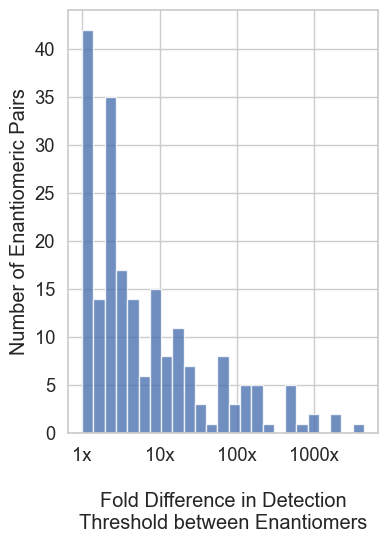

In [55]:
# Illustrate the magnitude differences across enantiomeric pairs in the dataset
model_helpers.fold_difference(half_coleman_data)

In [56]:
# Gets the appropriate parameter values for mordred model
# Gets the valid features (not null values) from feature data frame and the log_abs values from the feature dataframe
X_morded = mordred_data[finite_mordred]
y = mordred_data['log_abs']
X_morded = X_morded[y < 10]
y_mordred = y[y < 10]
Xn_mordred = pd.DataFrame(StandardScaler().fit_transform(X_morded), index=X_morded.index, columns=X_morded.columns)

c:\Users\Owner\Documents\liyahswebsite\enantiomerlist


In [61]:
# Gets the appropriate parameter values for Morgan model
# Gets the valid features (not null values) from feature data frame and the log_abs values from the feature dataframe
x_morgan = morgan_data[finite_morgan]
y_morgan = morgan_data["log_abs"]
x_morgan = x_morgan[y_morgan < 10]
y_morgan = y_morgan[y_morgan < 10]
Xn_morgan = pd.DataFrame(StandardScaler().fit_transform(x_morgan), index=x_morgan.index, columns=x_morgan.columns)

In [60]:
# Model for Morgan dad
model_helpers.create_model(Xn_morgan, y_morgan)

Text(0, 0.5, 'Predicted Detection\nThreshold Ratio')

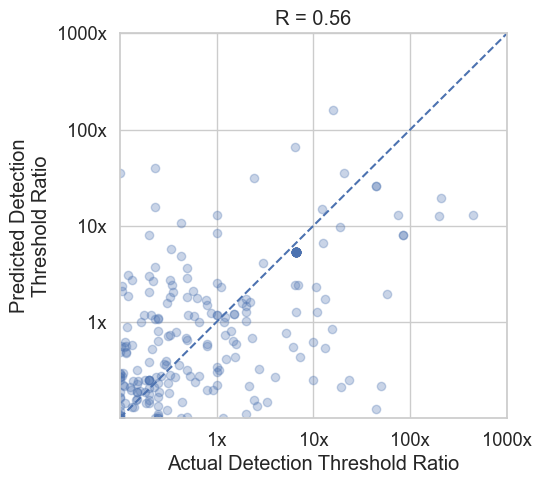

In [85]:
model_helpers.cross_val(Xn_morgan, y_morgan)

100%|██████████| 13/13 [01:08<00:00,  5.28s/it]


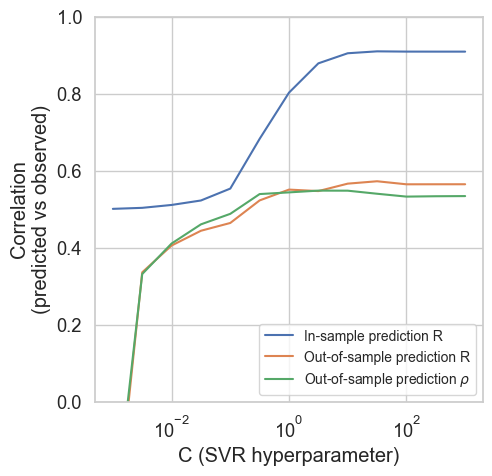

In [59]:
# Model for Mordred data
model_helpers.create_model(Xn_mordred, y_mordred)

c:\Users\Owner\Documents\liyahswebsite\enantiomerlist


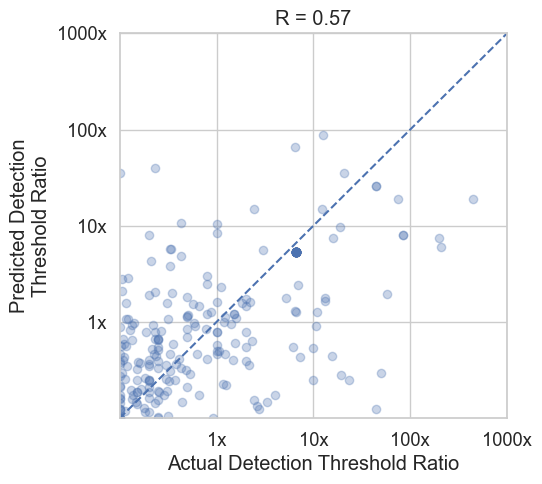

In [86]:
model_helpers.cross_val(Xn_mordred, y_mordred)

In [70]:
x_gme = g_model_embeddings.iloc[:,11:]
y_gme = g_model_embeddings["log_abs"]
Xn_gme = pd.DataFrame(StandardScaler().fit_transform(x_gme), index=x_gme.index, columns=x_gme.columns)

c:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


  0%|          | 0/13 [00:00<?, ?it/s]c:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
c:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  Futur

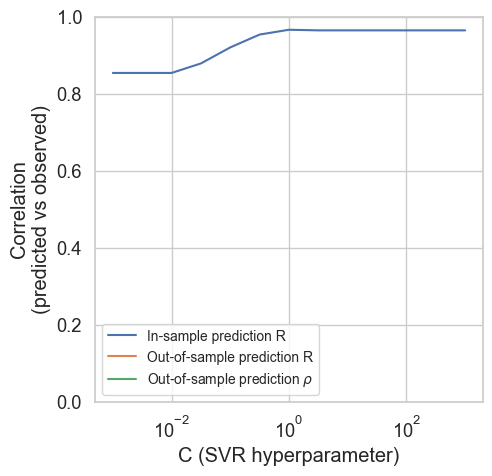

In [71]:
model_helpers.create_model(Xn_gme, y_gme)

### Liyah, stop here.  I can explain what I am doing in the next section another time.

In [39]:
from sklearn.feature_selection import RFE, RFECV
svr = SVR(C=10, kernel='linear')
rfe = RFE(svr, n_features_to_select=1, step=10)
#rfe.fit(Xn, y)

ValueError: Found input variables with inconsistent numbers of samples: [231, 232]

In [62]:
rfe.ranking_.max()

NameError: name 'rfe' is not defined

In [63]:
svr = SVR(C=10, kernel='rbf')
ns = range(1, 109, 1)
rs = pd.Series(index=ns, dtype=float)
for n in tqdm(ns):
    Xn_ = Xn[Xn.columns[rfe.ranking_ <= n]]
    y_predict = cross_val_predict(svr, Xn_, y, cv=LeaveOneOut(), n_jobs=-1)
    rs[n] = np.corrcoef(y, y_predict)[0, 1]

NameError: name 'SVR' is not defined

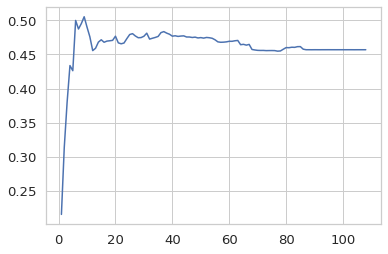

In [ ]:
rs.plot()

In [ ]:
Cs = np.logspace(-3, 3, 13)
rs_in = pd.Series(index=Cs, dtype=float)
rs_out = pd.Series(index=Cs, dtype=float)
rhos_out = pd.Series(index=Cs, dtype=float)
Xn_ = Xn[Xn.columns[rfe.ranking_ <= 10]]
for C in tqdm(Cs):
    svr = SVR(C=C, kernel='rbf')
    clf = svr
    #y_predict = cross_val_predict(rfr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    clf.fit(Xn_, y)
    y_predict_in = clf.predict(Xn_)
    y_predict_out = cross_val_predict(clf, Xn_, y, cv=LeaveOneOut(), n_jobs=-1)
    y_predict_in = np.clip(y_predict_in, 0, np.inf)
    y_predict_out = np.clip(y_predict_out, 0, np.inf)
    rs_in[C] = pearsonr(y, y_predict_in)[0]
    rs_out[C] = pearsonr(y, y_predict_out)[0]
    rhos_out[C] = spearmanr(y, y_predict_out)[0]

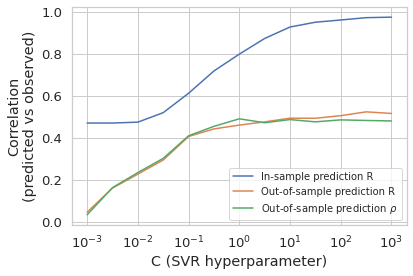

In [ ]:
rs_in.plot(label='In-sample prediction R')
rs_out.plot(label='Out-of-sample prediction R')
rhos_out.plot(label=r'Out-of-sample prediction $\rho$')
plt.xscale('log')
plt.ylabel('Correlation\n(predicted vs observed)')
plt.xlabel('C (SVR hyperparameter)')
plt.legend(fontsize=10)

In [ ]:
Xn_ = Xn[Xn.columns[rfe.ranking_ <= 10]]
rfr = RandomForestRegressor(n_estimators=100)
y_predict = cross_val_predict(rfr, Xn_, y, cv=LeaveOneOut(), n_jobs=-1)
np.corrcoef(y, y_predict)[0, 1]

0.4983942074677981

In [ ]:
rfr.fit(Xn_, y)
pd.Series(rfr.feature_importances_, Xn_.columns).sort_values(ascending=False).head(25)

det            0.176796
ATSC6dv        0.062489
Xp-5d          0.045340
TIC2           0.039908
ATSC4i         0.032647
piPC8          0.028903
ATSC1p         0.025059
ATSC8dv        0.018635
GATS5c         0.017560
SsssCH         0.016195
AATSC3c        0.015393
SdssC          0.015246
AXp-3d         0.014767
EState_VSA2    0.014738
JGI3           0.014481
ATS8v          0.014290
MATS5i         0.013840
ATSC7m         0.013457
VSA_EState7    0.013454
AATSC5d        0.013390
GATS3c         0.013261
ATSC8d         0.013127
GATS3se        0.012693
GATS1d         0.011737
GATS1s         0.011484
dtype: float64

Text(0, 0.5, 'Predicted Detection\nThreshold Ratio')

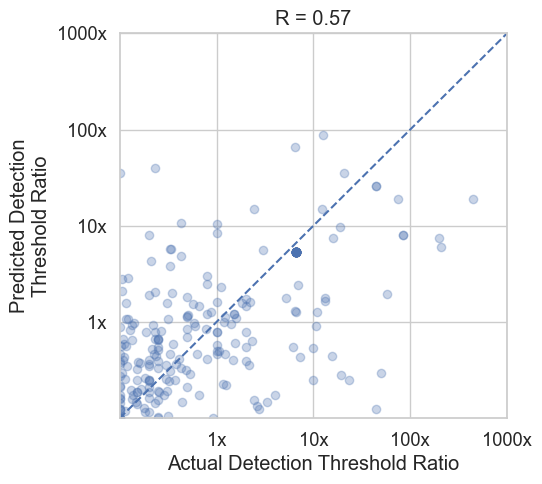

In [83]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
sns.set_style('whitegrid')
svr = SVR(C=10, kernel='rbf')
svr.fit(Xn_mordred, y_mordred)
y_predict = cross_val_predict(svr, Xn_mordred, y_mordred, cv=LeaveOneOut(), n_jobs=-1)
y_predict = np.clip(y_predict, 0, np.inf)
plt.figure(figsize=(5, 5))
plt.scatter(y_mordred, y_predict, alpha=0.3)
#maxx = y.max()*1.01
#plt.plot([0, maxx], [0, maxx], '--')
plt.plot([0, 4], [0, 4], '--')
plt.xlim(0, 4)
plt.ylim(0, 4)
#plt.xlim(0.9, maxx)
#plt.ylim(0.9, maxx)
plt.title('R = %.2g' % np.corrcoef(y_mordred, y_predict)[0, 1])
#ticks = range(5)
#plt.xticks(ticks)
#plt.yticks(ticks)
plt.xticks([1,2,3,4], ["1x", "10x", "100x", "1000x"])
plt.yticks([1,2,3,4], ["1x", "10x", "100x", "1000x"])
# plt.xticks(ticks, ['%d' % 10**x for x in ticks])
# plt.yticks(ticks, ['%d' % 10**x for x in ticks])
plt.xlabel('Actual Detection Threshold Ratio')
plt.ylabel('Predicted Detection\nThreshold Ratio')

Text(0, 0.5, 'Predicted Detection\nThreshold Ratio')

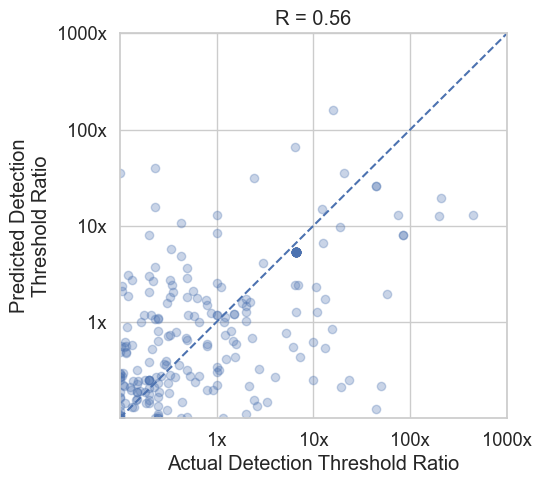

In [61]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
sns.set_style('whitegrid')
svr = SVR(C=10, kernel='rbf')
svr.fit(Xn_morgan, y_morgan)
y_predict = cross_val_predict(svr, Xn_morgan, y_morgan, cv=LeaveOneOut(), n_jobs=-1)
y_predict = np.clip(y_predict, 0, np.inf)
plt.figure(figsize=(5, 5))
plt.scatter(y_morgan, y_predict, alpha=0.3)
plt.plot([0, 4], [0, 4], '--')
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.title('R = %.2g' % np.corrcoef(y_morgan, y_predict)[0, 1])
plt.xticks([1,2,3,4], ["1x", "10x", "100x", "1000x"])
plt.yticks([1,2,3,4], ["1x", "10x", "100x", "1000x"])
plt.xlabel('Actual Detection Threshold Ratio')
plt.ylabel('Predicted Detection\nThreshold Ratio')

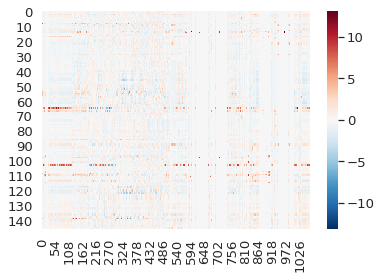

In [ ]:
sns.heatmap(svr.support_vectors_, cmap='RdBu_r')

In [ ]:
abraham = pyrfume.load_data('abraham_2011/abraham-2011-with-CIDs.csv')
abraham = abraham.dropna(subset=['SMILES'])
from pyrfume.features import smiles_to_mordred
abraham_mordred = smiles_to_mordred(abraham['SMILES'].values)

[-----------------------100%---------------------] 311 out of 311 complete (Finished embedding all molecules)
Computing Mordred features...


100%|██████████| 249/249 [00:09<00:00, 27.42it/s]


There are 249 molecules and 1826 features


In [ ]:
#X = abraham_mordred.join(abraham.set_index('SMILES').drop(['Substance', 'Group'], axis=1), how='inner', rsuffix='abr_')
abe_ok = ['MW',
 'Log (1/ODT)',
 'E',
 'S',
 'A',
 'B',
 'L',
 'V',
 'M',
 'AL',
 'AC',
 'ES',
 'C1',
 'C1AC',
 'C1AL',
 'HS',
 'C2',
 'C2Al',
 'C2AC']
X = abraham_mordred.join(abraham.set_index('SMILES')[['Log (1/ODT)']], how='inner', rsuffix='abr_')
y = X['Log (1/ODT)']
X = X.astype('float').drop('Log (1/ODT)', axis=1)
#finite_all = X.dropna(axis=1).columns.intersection(finite_mordred)
X = X[finite_mordred].fillna(0)
X = X.dropna(axis=1)
Xn = X.copy()
Xn[:] = StandardScaler().fit_transform(X)

KeyError: "['det'] not in index"

In [ ]:
Cs = np.logspace(-3, 3, 13)
rs_in = pd.Series(index=Cs, dtype=float)
rs_out = pd.Series(index=Cs, dtype=float)
rhos_out = pd.Series(index=Cs, dtype=float)
for C in tqdm(Cs):
    svr = SVR(C=C, kernel='rbf')
    clf = svr
    #y_predict = cross_val_predict(rfr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    clf.fit(Xn, y)
    y_predict_in = clf.predict(Xn)
    y_predict_out = cross_val_predict(clf, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    y_predict_in = np.clip(y_predict_in, 0, np.inf)
    y_predict_out = np.clip(y_predict_out, 0, np.inf)
    rs_in[C] = pearsonr(y, y_predict_in)[0]
    rs_out[C] = pearsonr(y, y_predict_out)[0]
    rhos_out[C] = spearmanr(y, y_predict_out)[0]

In [ ]:
rs_in.plot(label='In-sample prediction R')
rs_out.plot(label='Out-of-sample prediction R')
rhos_out.plot(label=r'Out-of-sample prediction $\rho$')
plt.xscale('log')
plt.ylabel('Correlation\n(predicted vs observed)')
plt.xlabel('C (SVR hyperparameter)')
plt.legend(fontsize=10)

In [ ]:
svr = SVR(C=1, kernel='rbf')
svr.fit(Xn, y)
X_ = mordred_data[finite_mordred]; y_ = mordred_data['log_abs']
X_ = X_.join(half_coleman_data.set_index('SMILES String')['det'])
X_ = X_[y_ < 10]
y_ = y_[y_ < 10]
Xn_ = pd.DataFrame(StandardScaler().fit_transform(X_), index=X_.index, columns=X_.columns)
X_['det'] = svr.predict(Xn_.drop('det', axis=1))
#y_predict = cross_val_predict(svr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)

In [ ]:
Xn_ = pd.DataFrame(StandardScaler().fit_transform(X_), index=X_.index, columns=X_.columns)
Cs = np.logspace(-3, 3, 13)
rs_in = pd.Series(index=Cs, dtype=float)
rs_out = pd.Series(index=Cs, dtype=float)
rhos_out = pd.Series(index=Cs, dtype=float)
for C in tqdm(Cs):
    svr = SVR(C=C, kernel='rbf')
    clf = svr
    #y_predict = cross_val_predict(rfr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    clf.fit(Xn_, y_)
    y_predict_in = clf.predict(Xn_)
    y_predict_out = cross_val_predict(clf, Xn_, y_, cv=LeaveOneOut(), n_jobs=-1)
    y_predict_in = np.clip(y_predict_in, 0, np.inf)
    y_predict_out = np.clip(y_predict_out, 0, np.inf)
    rs_in[C] = pearsonr(y_, y_predict_in)[0]
    rs_out[C] = pearsonr(y_, y_predict_out)[0]
    rhos_out[C] = spearmanr(y_, y_predict_out)[0]

In [ ]:
rs_in.plot(label='In-sample prediction R')
rs_out.plot(label='Out-of-sample prediction R')
rhos_out.plot(label=r'Out-of-sample prediction $\rho$')
plt.xscale('log')
plt.ylabel('Correlation\n(predicted vs observed)')
plt.xlabel('C (SVR hyperparameter)')
plt.legend(fontsize=10)